In [0]:
# !pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.8 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 1.8/1.8 MB 79.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

In [0]:
!pip install accelerate peft bitsandbytes transformers trl

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:

import torch 
import os
from datasets import load_dataset
from transformers import (AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig,HfArgumentParser, TrainingArguments, pipeline, logging)
from peft import PeftModel, LoraConfig
from trl import SFTTrainer, SFTConfig ## the actual trainer class
os.environ["PYTORCH_CUDA_ALLOC_CONF"] ="expandable_segments:True"

import gc
import torch
torch.cuda.empty_cache()

2025-01-05 17:35:44.686584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736098544.697974   22775 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736098544.701502   22775 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 17:35:44.714621: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [0]:
# Load dataset (you can process it here)
dataset_name = "mlabonne/guanaco-llama2-1k"
dataset = load_dataset(dataset_name, split="train")

/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:45: UserWarning: The cache_dir for this dataset is /root/.cache, which is not a persistent path.Therefore, if/when the cluster restarts, the downloaded dataset will be lost.The persistent storage options for this workspace/cluster config are: [DBFS].Please update either `cache_dir` or the environment variable `HF_DATASETS_CACHE`to be under one of the following root directories: ['/dbfs/']
  warnings.warn(warning_message)
/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:14: UserWarning: During large dataset downloads, there could be multiple progress bar widgets that can cause performance issues for your notebook or browser. To avoid these issues, use `datasets.utils.logging.disable_progress_bar()` to turn off the progress bars.
  warnings.warn(


Your GPU supports bfloat16: accelerate training with bf16=True


In [0]:
running_sum = 0
for i in dataset['text']:
    running_sum += len(i)
print(running_sum/len(dataset['text']))


1499.042


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

11443


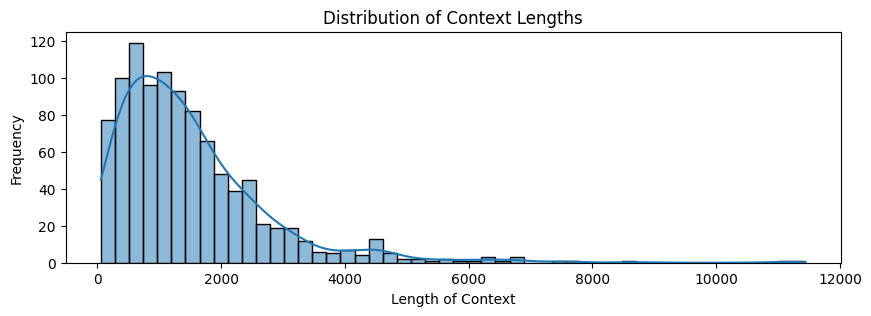

In [0]:
texts = dataset['text']
context_lengths = np.asarray([len(i) for i in texts])
print(max(context_lengths))
plt.figure(figsize=(10, 3))
sns.histplot(context_lengths, bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

In [0]:
user_questions = []
assistant_answers = []
charac_1 = "[INST]"
charac_2 = "[/INST]"

for i in dataset['text']:
    index_1 = i.find(charac_1)
    index_2 = i.find(charac_2)
    user_questions.append(i[index_1:index_2])
    assistant_answers.append(i[index_2:].replace("</s>", ""))

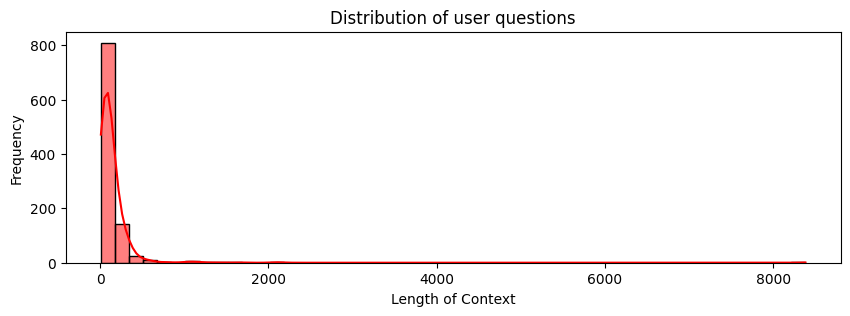

In [0]:
user_lengths = np.asarray([len(i) for i in user_questions])
assistant_lengths = np.asarray([len(i) for i in assistant_answers])
plt.figure(figsize=(10, 3))
sns.histplot(user_lengths, bins=50, kde=True, color= 'red')
plt.title('Distribution of user questions')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

10869


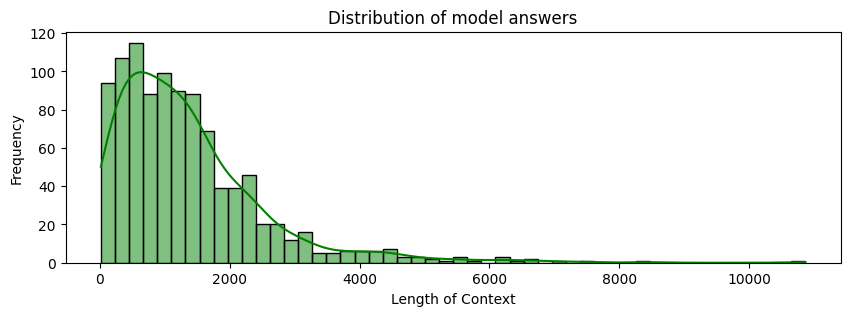

In [0]:
plt.figure(figsize=(10, 3))
sns.histplot(assistant_lengths, bins=50, kde=True, color = 'green')
print(max(assistant_lengths))
plt.title('Distribution of model answers')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

## Lets define the fine tuning process!

In [0]:
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization process (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 2

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 2

# Batch size per GPU for evaluation
per_device_eval_batch_size = 1

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 2

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 5

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}


In [0]:
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

In [0]:
## get quantised model 
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [0]:
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

In [0]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = SFTConfig(
    per_device_train_batch_size= per_device_train_batch_size,
    gradient_accumulation_steps= gradient_accumulation_steps,
    warmup_steps = 5,
    logging_steps = logging_steps,
    num_train_epochs = num_train_epochs, # Set this for 1 full training run.
    learning_rate = learning_rate,
    fp16 = fp16,
    bf16 = bf16,
    optim = optim,
    weight_decay = weight_decay,
    lr_scheduler_type = lr_scheduler_type,
    output_dir = output_dir,
    report_to = "tensorboard",
    max_seq_length = max_seq_length,
    packing = packing, # Can make training 5x faster for short sequences.
    dataset_text_field="text",
)

In [0]:
# On Ubuntu/Debian:
!sudo apt-get install libaio-dev





E: Unable to locate package libaio-dev


In [0]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    processing_class=tokenizer,
    args=training_arguments,
)

# Train model
trainer.train()

[2025-01-05 17:36:28,723] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.4
 [WARNING]  using untested triton version (3.0.0), only 1.0.0 is known to be compatible


/databricks/python/lib/python3.12/site-packages/deepspeed/runtime/zero/linear.py:47: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @autocast_custom_fwd
/databricks/python/lib/python3.12/site-packages/deepspeed/runtime/zero/linear.py:66: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @autocast_custom_bwd
[rank0]:[W105 17:36:33.863942996 reducer.cpp:1400] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterat

Step,Training Loss


---------------------------------------------------------------------------
OutOfMemoryError                          Traceback (most recent call last)
File <command-557281251197422>, line 11
      2 trainer = SFTTrainer(
      3     model=model,
      4     train_dataset=dataset,
   (...)
      7     args=training_arguments,
      8 )
     10 # Train model
---> 11 trainer.train()

File /databricks/python/lib/python3.12/site-packages/mlflow/utils/autologging_utils/safety.py:460, in safe_patch.<locals>.safe_patch_function(*args, **kwargs)
    441 if (
    442     active_session_failed
    443     or autologging_is_disabled(autologging_integration)
   (...)
    454     # warning behavior during original function execution, since autologging is being
    455     # skipped
    456     with set_non_mlflow_warnings_behavior_for_current_thread(
    457         disable_warnings=False,
    458         reroute_warnings=False,
    459     ):
--> 460         return original(*args, **kwargs)
    46

In [0]:

%load_ext tensorboard
%tensorboard --logdir results/runs

Your log directory might be ephemeral to the cluster, which will be deleted after cluster termination or restart. You can choose a log directory under /dbfs/ or /Volumes/ to persist your logs in DBFS or UC Volumes.
Tensorboard may not be displayed in the notebook cell output when 'Third-party iFraming prevention' is disabled. You can still use Tensorboard by clicking the link below to open Tensorboard in a new tab. To enable Tensorboard in notebook cell output, please ask your workspace admin to enable 'Third-party iFraming prevention'.


Launching TensorBoard...

Open in a new tab
 
 Note: TensorBoard is only available when this notebook remains attached to the cluster. 
 
 
 Note: This cell needs to be re-run for TensorBoard to be available if this notebook is imported into a different workspace.

In [0]:
trainer.model.save_pretrained(new_model)

In [0]:
# Run text generation pipeline with our next model
prompt = "What is a large language model?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[INST] What is a large language model? [/INST] A large language model is a type of artificial intelligence (AI) model that is trained on a large dataset of text, and is designed to generate human-like language. This can include tasks such as text generation, language translation, and chatbots. These models are typically trained on large datasets of text, and are designed to learn patterns and relationships in language.

Some examples of large language models include:

* BERT (Bidirectional Encoder Representations from Transformers): A popular language model that is trained on a large dataset of text, and is designed to generate human-like language.
* RoBERTa (Robustly Optimized BERT Pretraining Approach): A variant of BERT that is trained on a larger dataset of text, and is designed to generate even more human-like language.
* Longformer (Long-range dependence transform


In [0]:
# Empty VRAM
import gc
import torch
torch.cuda.empty_cache()
